In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, ifft
from math import floor
from os import listdir
from os.path import isfile, join
import json
import matplotlib
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.rcParams['figure.figsize'] = [6.4, 4.8]

In [2]:
csi_base_dir = "/home/geosearchef/csi/csi-repo/data/"
csi_dir_breathing_fast = join(csi_base_dir, "csi-2020-08-20/csi-breathingFast_2020-08-20_18:28:07/")
csi_dir_breathing_slow = join(csi_base_dir, "csi-2020-08-20/csi-breathingSlow_2020-08-20_18:26:49/")
csi_dir_breathing_weak = join(csi_base_dir, "csi-2020-08-20/csi-breathingWeak_2020-08-20_18:27:27/")
csi_dir_breathing_direct_strong = join(csi_base_dir, "csi-2020-08-21/csi-breathingDirectReflectStronger_2020-08-21_15:22:35")
csi_dir_breathing_direct_very_weak = join(csi_base_dir, "csi-2020-08-21/csi-breathingDirectReflectVeryWeak_2020-08-21_15:20:44")
csi_dir_breathing_periodic_movement = join(csi_base_dir, "csi-2020-08-21/csi-rockingBackAndForth_2020-08-21_15:24:47")

ecg_first_test_data = join(csi_base_dir, "ecg-recording_2020-11-21_19:39:33/")
ecg_500hz_chest = join(csi_base_dir, "ecg-2020-12-08/ecg-500hz-chest_2020-12-08_20:03:12/")
ecg_armfoot = join(csi_base_dir, "ecg-2020-12-08/ecg-qrs-armfoot_2020-12-08_19:20:37/")
ecg_armfoot_nosupply = join(csi_base_dir, "ecg-2020-12-08/ecg-armfoot_nosupply_2020-12-08_19:33:10/") # without powersupply
ecg_500hz_armfoot_nosupply = join(csi_base_dir, "ecg-2020-12-08/ecg-500hz-armfoot-distancefromgrid_2020-12-08_19:48:23/")

## Data loading

In [3]:
# CSI recording to be used
csi_dir = csi_dir_breathing_fast

In [4]:
# load data
csi_files = sorted(listdir(csi_dir))
csi_recording = []
for filename in csi_files:
    if not filename.endswith(".csi"):
        continue
    
    with open(join(csi_dir, filename), "r") as file:
        individual_packets = json.load(file) # each file contains an array of packets
        for packet in individual_packets:
            csi_recording.append(packet)
    if len(csi_recording) % 200 == 0:
        print(f"Loading {len(csi_recording)} / {len(csi_files)} files")

# rescale timestamps
start_time = csi_recording[0]["clientTimestamp"]
for packet in csi_recording:
    packet["clientTimestamp"] -= start_time
total_duration_ms = max([entry["clientTimestamp"] for entry in csi_recording])
timestamps = [packet["clientTimestamp"] for packet in csi_recording]

print(f"Recording with {len(csi_recording)} entries, {total_duration_ms} ms loaded")

Loading 200 / 703 files
Loading 400 / 703 files
Loading 600 / 703 files
Recording with 702 entries, 15630 ms loaded


In [5]:
# The CSI is already scaled an permuted
rx_antennas = csi_recording[0]["intelCsiNotification"]["Nrx"]
tx_antennas = csi_recording[0]["intelCsiNotification"]["Ntx"]
relative_timestamps = [ packet["clientTimestamp"] / 1000 for packet in csi_recording]

csi_recording[0]["intelCsiNotification"]

{'timestamp_low': -589557196,
 'bfee_count': 7892,
 'Nrx': 3,
 'Ntx': 1,
 'rssi_a': 39,
 'rssi_b': 9,
 'rssi_c': 22,
 'noise': -90,
 'agc': 46,
 'antenna_sel': 24,
 'perm': [0, 2, 1],
 'len': 192,
 'fake_rate_n_flags': 8455}

## Amplitude / Phase extraction

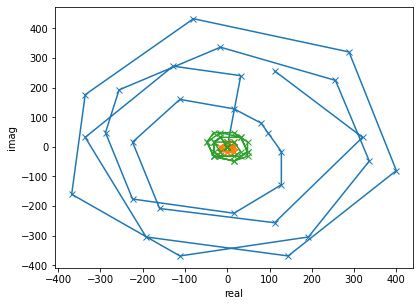

In [6]:
def plot_csi(rx, tx, csi_matrix):
    if not matplotlib.get_backend().endswith("inline"):
        matplotlib.use("module://ipykernel.pylab.backend_inline")
    plt.xlabel("real")
    plt.ylabel("imag")
    plt.plot([v["real"] for v in csi_matrix[rx][tx]], [v["imag"] for v in csi_matrix[rx][tx]], "x-")
    
def plot_csi_all_antennas(csi_matrix):
    for rx in range(rx_antennas):
        for tx in range(tx_antennas):
            plot_csi(rx, tx, csi_matrix)
    

plot_csi_all_antennas(csi_recording[0]["csi_matrix"])

Only one antenna is connected.

In [7]:
# Shape [packet][rx][tx][subcarrier]
csi_complex = [[[[complex(c["real"], c["imag"]) for c in tx] for tx in rx] for rx in packet["csi_matrix"]] for packet in csi_recording]
csi_amplitudes = [[[[np.abs(c) for c in tx] for tx in rx] for rx in packet] for packet in csi_complex]
csi_phases_uncorrected = [[[[np.angle(c) for c in tx] for tx in rx] for rx in packet] for packet in csi_complex]

csi_complex = np.array(csi_complex)
csi_amplitudes = np.array(csi_amplitudes)
csi_phases_uncorrected = np.array(csi_phases_uncorrected)

def plot_subcarrier_data(rx, tx, csi_data, ylabel=""):
    plt.rcParams['figure.figsize'] = [15, 8]
    if not matplotlib.get_backend().endswith("inline"):
        matplotlib.use("module://ipykernel.pylab.backend_inline")
    plt.xlabel("subcarrier")
    plt.ylabel(ylabel)
    plt.plot(csi_data[rx][tx][0:30], "-")

### Amplitude

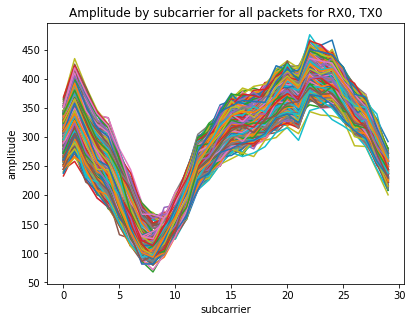

In [8]:
f = plt.figure()
plt.title("Amplitude by subcarrier for all packets for RX0, TX0")
for packet in csi_amplitudes:
    plot_subcarrier_data(0, 0, packet, "amplitude")

### Phase

PhaseBeat used the Phase diff for respiratory and heart rate extraction, is amplitude even sensitive enough? Phase looks like it's offset constantly by subcarrier, can this be corrected?:

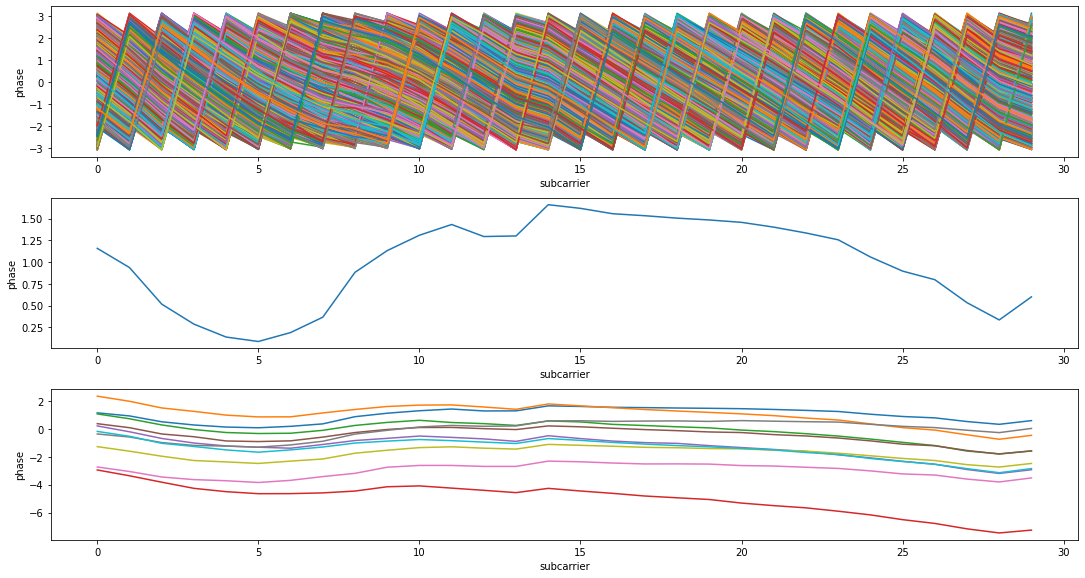

In [9]:
f, ax = plt.subplots(3, 1)
f.tight_layout(h_pad=2)


plt.subplot(3,1,1)
for packet in csi_phases_uncorrected:
    plot_subcarrier_data(0, 0, packet, "phase")

# correct phase
csi_phases = np.copy(csi_phases_uncorrected)
for packet in csi_phases:
    for rx in packet:
        for tx in rx:
            for i in range(30):
                tx[i] = tx[i] + i * ((4.0 * 2.0 * np.pi) / 30.0)
                tx[i] = (tx[i] + np.pi) % (2 * np.pi) - np.pi
                if i >= 1 and tx[i] - tx[i-1] > np.pi:
                    tx[i] = tx[i] - 2*np.pi
                if i >= 1 and tx[i-1] - tx[i] > np.pi:
                    tx[i] = tx[i] + 2*np.pi

# unwrap phase data
csi_phases_unwrapped = np.copy(csi_phases)
for packet in csi_phases_unwrapped:
    for rx in packet:
        for tx in rx:
            for i in range(30):
                if i >= 1 and tx[i] - tx[i-1] > np.pi:
                    tx[i] = tx[i] - 2*np.pi
                if i >= 1 and tx[i-1] - tx[i] > np.pi:
                    tx[i] = tx[i] + 2*np.pi

plt.subplot(3,1,2)
plot_subcarrier_data(0, 0, csi_phases[0], "phase")
plt.subplot(3,1,3)
for packet in csi_phases[:10]:
    plot_subcarrier_data(0, 0, packet, "phase")
    



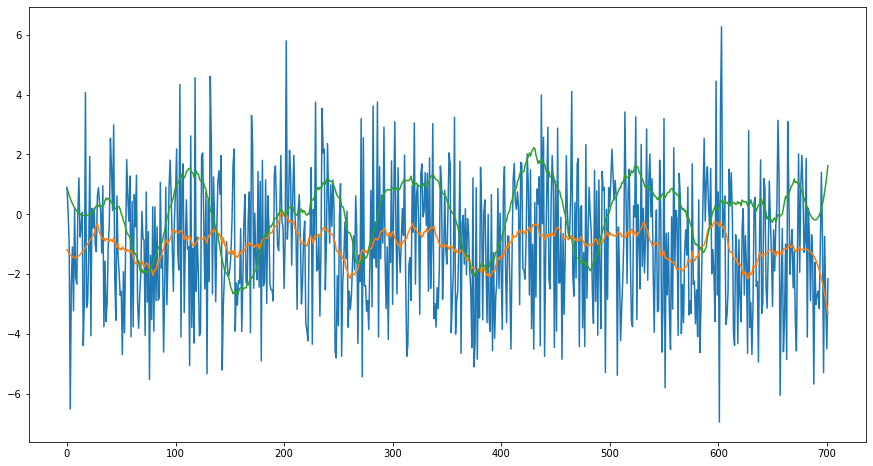

In [10]:
def phase_signal(rx, tx, carrier):
    return csi_phases[:,rx,tx,carrier]
def amplitude_signal(rx, tx, carrier):
    return csi_amplitudes[:,rx,tx,carrier]

f = plt.figure()
plot(phase_signal(0, 0, 25))
plot(savgol_filter(phase_signal(0, 0, 25), 51, 3))
plot((savgol_filter(amplitude_signal(0, 0, 25), 51, 3) - np.mean(savgol_filter(amplitude_signal(0, 0, 25), 51, 3))) / 10)

# TODO
 - plot over time
 - plot difference in itself over time

Might even be able to use phase or phase diff along subcarriers itself instead of phase diff (as PhaseBeat did, which is chaotic with multiple antennas connected).

## Signal preprocessing

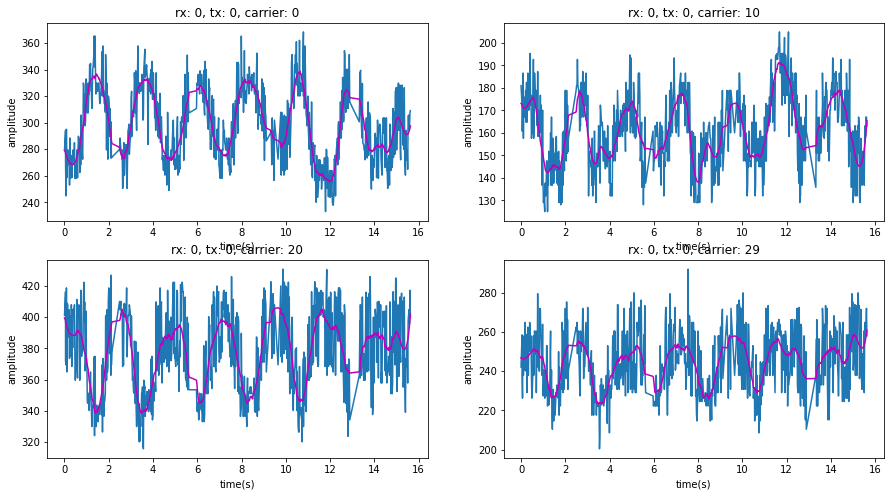

In [11]:
from scipy.signal import savgol_filter


def plot_amplitude_over_time(rx, tx, carrier):
    #if not matplotlib.get_backend().endswith("nbAgg"):
    #    matplotlib.use("nbAgg")
    #f = plt.figure()
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.title(f"rx: {rx}, tx: {tx}, carrier: {carrier}")
    plt.xlabel("time(s)")
    plt.ylabel("amplitude")
    plt.plot(relative_timestamps, amplitude_signal(rx,tx,carrier))
    plt.plot(relative_timestamps, savgol_filter(amplitude_signal(rx,tx, carrier), 51, 3), "m")

f = plt.figure()
plt.title("Amplitude over time (respiratory)")
plt.subplot(2,2,1)
plot_amplitude_over_time(0, 0, 0)
plt.subplot(2,2,2)
plot_amplitude_over_time(0, 0, 10)
plt.subplot(2,2,3)
plot_amplitude_over_time(0, 0, 20)
plt.subplot(2,2,4)
plot_amplitude_over_time(0, 0, 29)
#plot_amplitude_over_time(0, 0, 25)

## Discrete Fourier Transform - Respiratory rate

Packets: 702
SignalLen: 782
FFT Bins: 782
Resolution: 3.8363171355498724 bpm
Interpolated peak freq: 26.067580933081725 bpm


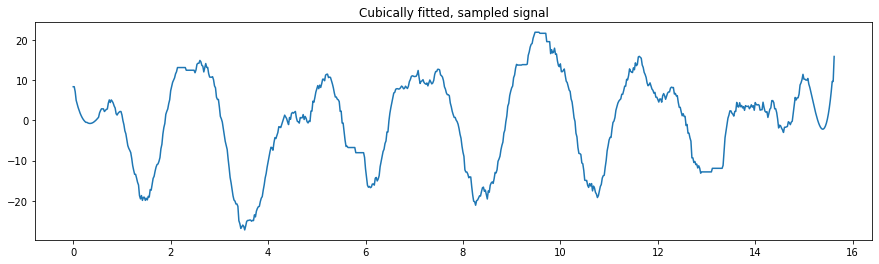

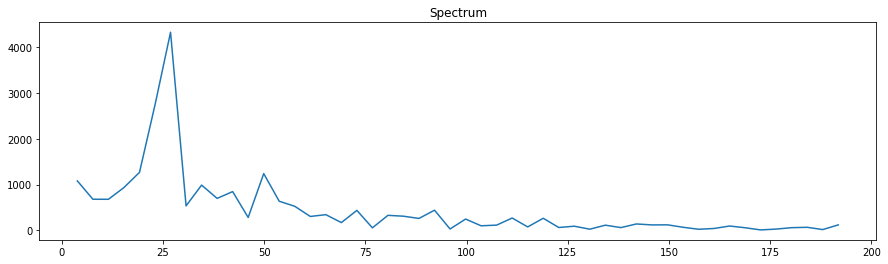

In [12]:
# Apply DFT
sampling_freq = 50 # TODO: use average of durations or sample + interpolate?

signal = amplitude_signal(0,0,25)

smoothed_signal = savgol_filter(signal, 51, 3)

# Signal interpolation
def interpolateSignal(freq,signal):  # TODO: this is no interpolation (yet)
    sampling_times = np.arange(0, total_duration_ms / 1000.0, 1.0 / freq) * 1000.0
    sampled_signal_index = [csi_recording.index(min(csi_recording, key=lambda e: np.abs(e["clientTimestamp"] - time))) for time in sampling_times]
    sampled_signal = signal[sampled_signal_index]
    return sampled_signal, sampling_times


sampled_signal, sampling_times = interpolateSignal(sampling_freq, smoothed_signal)
mean = np.mean(sampled_signal)
sampled_signal = sampled_signal - mean

#f = plt.figure()
#plot(signal)
#plot(smoothed_signal)
plt.rcParams['figure.figsize'] = [15, 4]
plt.title("Cubically fitted, sampled signal")
plot(sampling_times / 1000, sampled_signal)

bins = fft(sampled_signal)
binSpacing = sampling_freq / 2.0 / (len(bins) / 2.0) # according to nyquist, the FFT can resolve up to sampling_freq/2 frequencies, spread equally accross all bins
usedBins = floor(len(bins)/2.0)

magnitudeByBin = [ np.abs(c) for c in bins[1:usedBins]]
binFrequencies = np.arange(1, usedBins, 1) * binSpacing

f = plt.figure()
plt.title("Spectrum")
plot(binFrequencies[:50] * 60.0, magnitudeByBin[:50])

# interpolate result (https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html)
maxIndex = magnitudeByBin.index(max(magnitudeByBin))
lowerIndex = max(maxIndex - 1, 0)
upperIndex = min(maxIndex + 1, len(magnitudeByBin) - 1)

offset = (magnitudeByBin[upperIndex] - magnitudeByBin[lowerIndex]) / (2.0 * (magnitudeByBin[maxIndex] * 2.0 - magnitudeByBin[lowerIndex] - magnitudeByBin[upperIndex]));
interpolatedPeakFreq = binFrequencies[maxIndex] + offset * binSpacing

print(f"Packets: {len(signal)}")
print(f"SignalLen: {len(sampled_signal)}")
print(f"FFT Bins: {len(bins)}")
print(f"Resolution: {binSpacing * 60.0} bpm")
print(f"Interpolated peak freq: {interpolatedPeakFreq * 60.0} bpm")

## DFT removal

What if I transform the signal to frequency space, remove all wanted components, transform back and and subtract the result from the original signal? Does this remove low frequency components without destroying time resolution?

Zeroing the first 10 bins


/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/scipy/signal/_savitzky_golay.py:333: ComplexWarning: Casting complex values to real discards the imaginary part
  x = x.astype(np.float64)
/home/geosearchef/csi/csi-repo/experiments/analysis/.

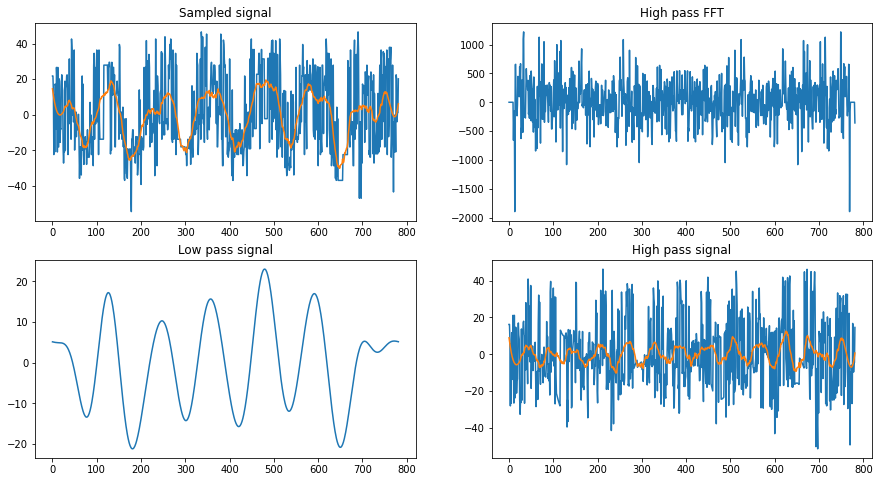

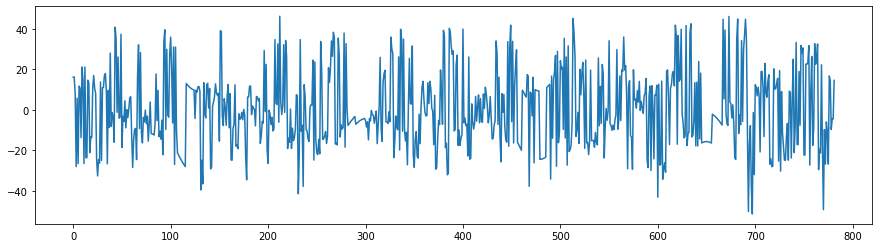

In [13]:
sampling_freq = 50
max_freq_to_filter = 0.66
max_freq_to_filter = 0.66

signal = amplitude_signal(0,0,25)

sampled_signal, sampling_times = interpolateSignal(sampling_freq, signal)
mean = np.mean(sampled_signal)
sampled_signal = sampled_signal - mean


bins = fft(sampled_signal)
binSpacing = sampling_freq / 2.0 / (len(bins) / 2.0)

cutoff_bin = floor(0.66 / binSpacing)

low_pass_bins = np.copy(bins)
high_pass_bins = np.copy(bins)

print(f"Zeroing the first {cutoff_bin} bins")
high_pass_bins[1:cutoff_bin] = 0
high_pass_bins[(len(bins)-1-cutoff_bin):len(bins)-1] = 0

low_pass_bins[cutoff_bin:(len(bins)-1-cutoff_bin)] = 0

high_pass_signal = ifft(high_pass_bins)
low_pass_signal = ifft(low_pass_bins)

plt.rcParams['figure.figsize'] = [15, 8]
f = plt.figure()
plt.subplot(2,2,1)
plt.title("Sampled signal")
plot(sampled_signal)
plot(savgol_filter(sampled_signal, 51, 3))
plt.subplot(2,2,2)
plt.title("High pass FFT")
plot(high_pass_bins)
plt.subplot(2,2,3)
plt.title("Low pass signal")
plot(low_pass_signal)
plt.subplot(2,2,4)
plt.title("High pass signal")
plot(high_pass_signal)
plot(savgol_filter(high_pass_signal, 51, 3))

plt.rcParams['figure.figsize'] = [15, 4]
f = plt.figure()
plot(high_pass_signal)

- Low pass is respiratoryrate
- High pass likely still contains variability information
- Bandpass signal would contain heart rate, but no HRV
- How about detecting / reconstructing heart rate with passband and then searching for peaks in the original signal around detected locations

*What is the periodic signal after filtering out breathing in the high pass?*

14 / 16.5s = 0.85 Hz = 50,9 bpm  ~  2 x 26 bpm    Likely just an octave above the breathing frequency.

## Wavelet transform

In [14]:
import pywt
pywt.wavelist(kind="discrete")

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

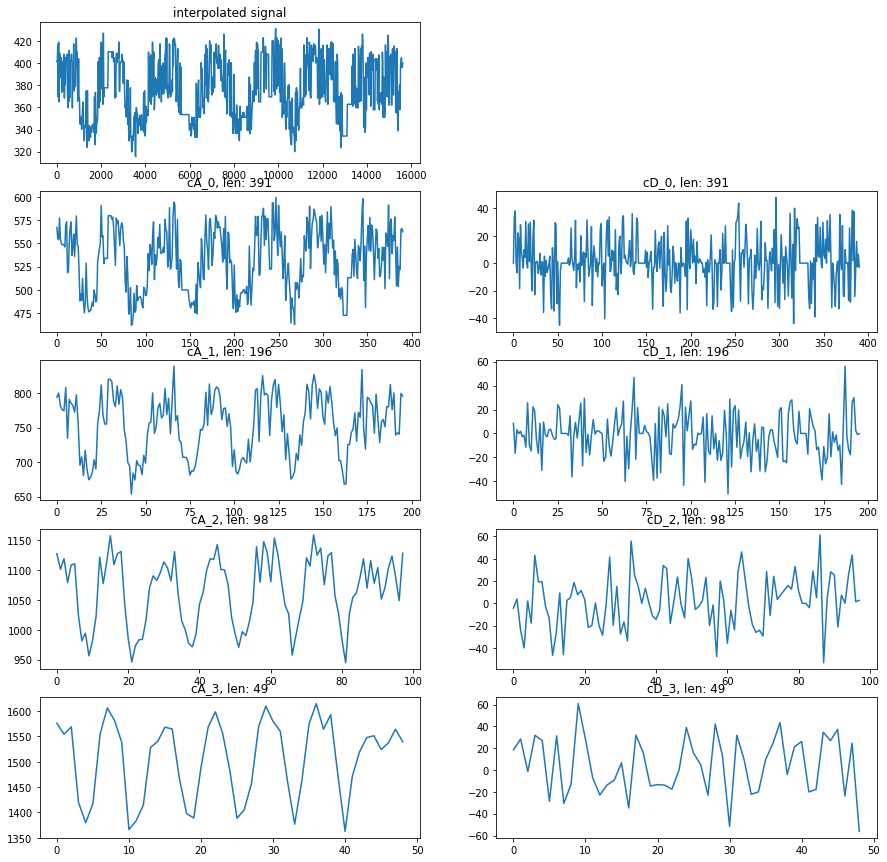

In [15]:
# DWT (FWT), single level

wavelet = "db1"  # TODO: which wavelet to use?
level = 4
sampling_freq = 50
signal, t = interpolateSignal(sampling_freq, amplitude_signal(0,0,20))

plt.rcParams['figure.figsize'] = [15, 15]
f = plt.figure()
plt.subplot(level+1,2,1)
plt.title("interpolated signal")
plt.plot(t,signal)

cAs = []
cDs = []
input_signal = signal
for i in range(level):
    cA, cD = pywt.dwt(input_signal, wavelet)
    cAs.append(cA)
    cDs.append(cD)
    
    plt.subplot(level+1,2,3+i*2)
    plt.title(f"cA_{i}, len: {len(cA)}") # TODO: add freq
    plt.plot(cA)
    plt.subplot(level+1,2,4+i*2)
    plt.title(f"cD_{i}, len: {len(cD)}")
    plt.plot(cD)
    
    input_signal = cA # half the resolution


plt.rcParams['figure.figsize'] = [15, 8]


#plt.subplot(2,2,2)
#plt.plot(timestamps, amplitude_signal(0,0,20))
#plt.subplot(2,2,3)
#plt.title("temporal gaps")
#plt.plot([packet["clientTimestamp"] for packet in csi_recording], np.repeat(1.0, len(csi_recording)), "x", markersize = 1)

- FWT removes detail step by step, cA is the new input to the 1-step DWT
- each cD contains a certain frequency range
- WHILE MAINTAINING TIME LOCALITY; HRV would still be present
- PhaseBeat uses detail coefficients 3 + 4

*last cD could be used for getting respiratory rate from peak to peak distance, FWT is basically an advanced (different wavelets, not just sine), localized (preseves time) fourier transform*

**Idea:** Use Bandpass from FFT / Wavelet for heart rate detection / signal reconstruction and then search peaks in sum of detail coefficients, as they are still time localized

/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/geosearchef/csi/csi-repo/experiments/analysis/.venv/lib64/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


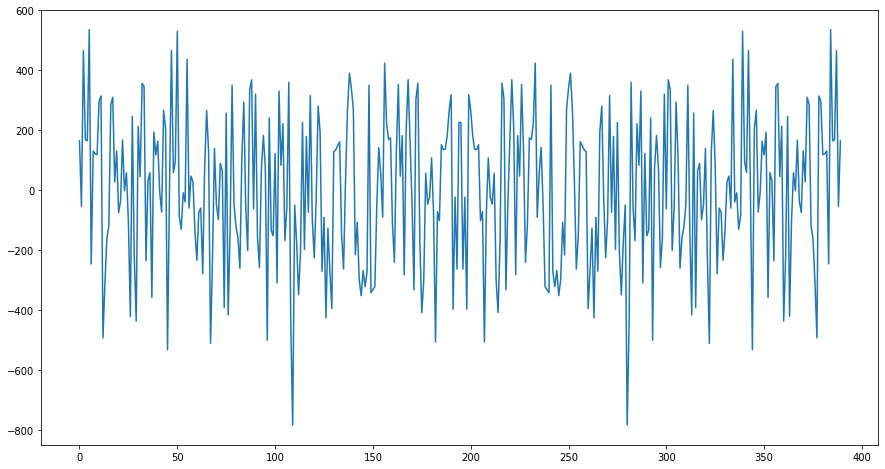

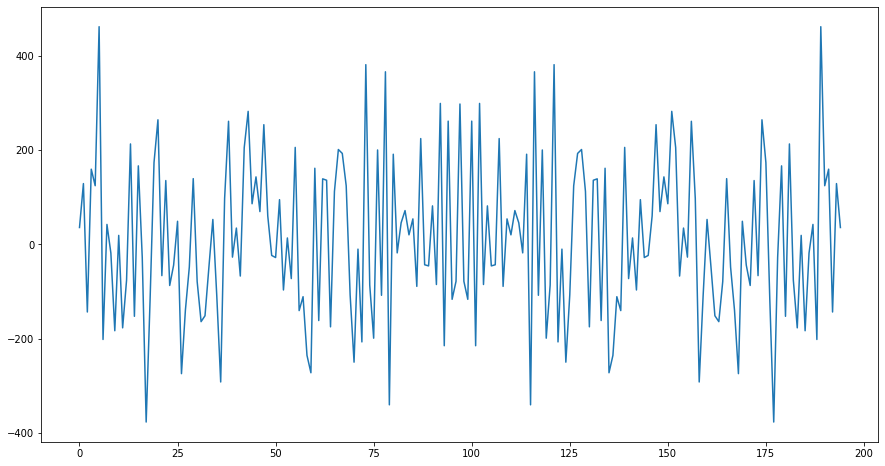

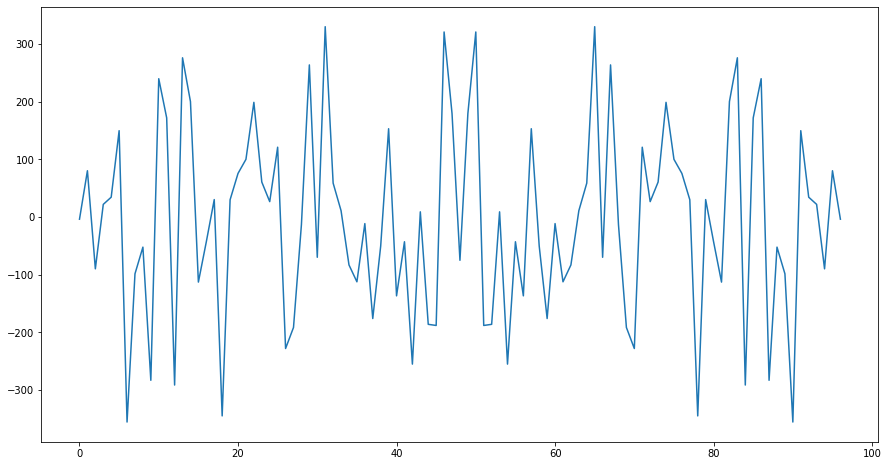

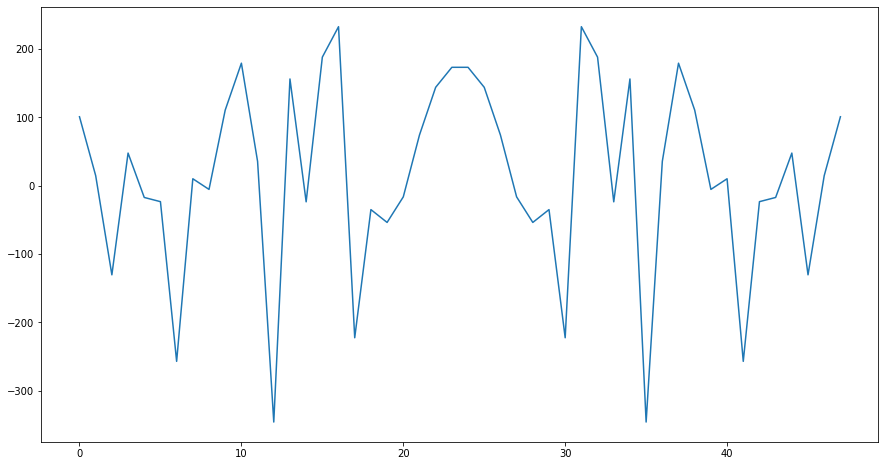

In [16]:
for cD in cDs:
    f = plt.figure()
    plot(fft(cD)[1:])

In [17]:
# DWT, multi level


In [18]:
# PWT

# ECG

In [19]:
# ECG recording to be used
ecg_dir = ecg_500hz_armfoot_nosupply

In [20]:
# load data
ecg_files = sorted(listdir(ecg_dir))
ecg_recording = []
for filename in ecg_files:
    if not filename.endswith(".ecg"):
        continue
    
    with open(join(ecg_dir, filename), "r") as file:
        records = json.load(file)
        for record in records:
            ecg_recording.append(record)
    if len(ecg_recording) % 200 == 0:
        print(f"Loading {len(ecg_recording)} / {len(ecg_files)} files")


Loading 200 / 16440 files
Loading 400 / 16440 files
Loading 600 / 16440 files
Loading 800 / 16440 files
Loading 1000 / 16440 files
Loading 1200 / 16440 files
Loading 1400 / 16440 files
Loading 1600 / 16440 files
Loading 1800 / 16440 files
Loading 2000 / 16440 files
Loading 2200 / 16440 files
Loading 2400 / 16440 files
Loading 2600 / 16440 files
Loading 2800 / 16440 files
Loading 3000 / 16440 files
Loading 3200 / 16440 files
Loading 3400 / 16440 files
Loading 3600 / 16440 files
Loading 3800 / 16440 files
Loading 4000 / 16440 files
Loading 4200 / 16440 files
Loading 4400 / 16440 files
Loading 4600 / 16440 files
Loading 4800 / 16440 files
Loading 5000 / 16440 files
Loading 5200 / 16440 files
Loading 5400 / 16440 files
Loading 5600 / 16440 files
Loading 5800 / 16440 files
Loading 6000 / 16440 files
Loading 6200 / 16440 files
Loading 6400 / 16440 files
Loading 6600 / 16440 files
Loading 6800 / 16440 files
Loading 7000 / 16440 files
Loading 7200 / 16440 files
Loading 7400 / 16440 files
Loadi

In [21]:
ecg_recording[0]

{'value': 0.45372406, 'clientTimestamp': 1607453335504, 'messageId': 52371}

## Sample ECG signal
The ECG signal needs to be sampled based on clientTimestamps to align with the CSI signal

In [22]:
# TODO
ecg_signal = np.array([record["value"] for record in ecg_recording])

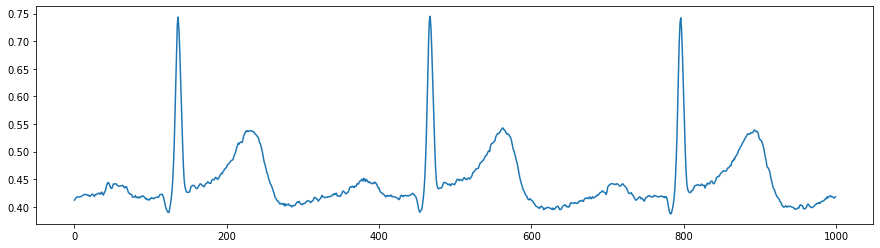

In [25]:
plot_interval = 2000

plt.rcParams['figure.figsize'] = [15, 4]
fig = plt.figure()
plt.plot(ecg_signal[1000:plot_interval])
#plt.plot(savgol_filter(ecg_signal, 5, 3)[:plot_interval])

- HRV analysis / methods: https://imotions.com/blog/heart-rate-variability/
	- Pan-Tompkins algorithm for peak detection?
	- rMSSD  (square difference between two intervals, then average, take the root)
- poincare plot

This plot doesn't match the expected QRS complex, did I hook up the electrodes incorrectly?

### Simple threshold peak detection

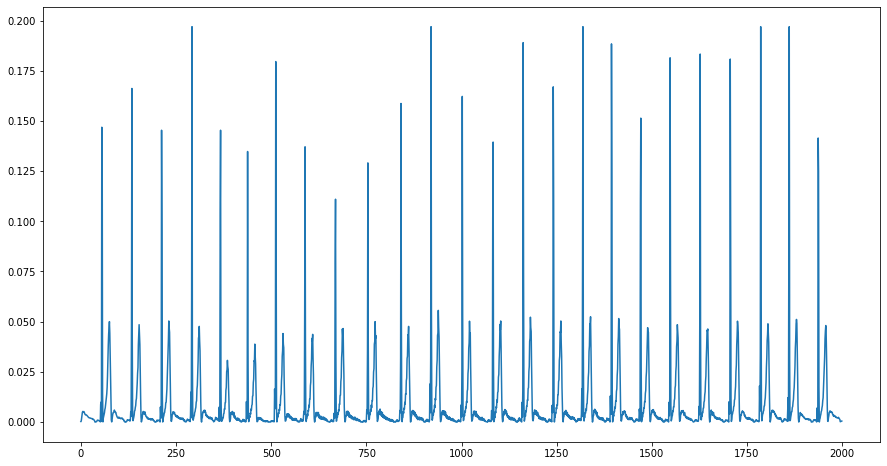

In [29]:
ecg_signal = ecg_signal - np.mean(ecg_signal)
squared_ecg_signal = np.array(ecg_signal)**2
plt.plot(squared_ecg_signal[:plot_interval])

[55,
 134,
 212,
 292,
 367,
 438,
 512,
 589,
 669,
 754,
 841,
 920,
 1002,
 1083,
 1162,
 1241,
 1319,
 1394,
 1471,
 1548,
 1627,
 1706,
 1786,
 1861,
 1937,
 2014,
 2093,
 2174,
 2256,
 2336,
 2411,
 2488,
 2563]

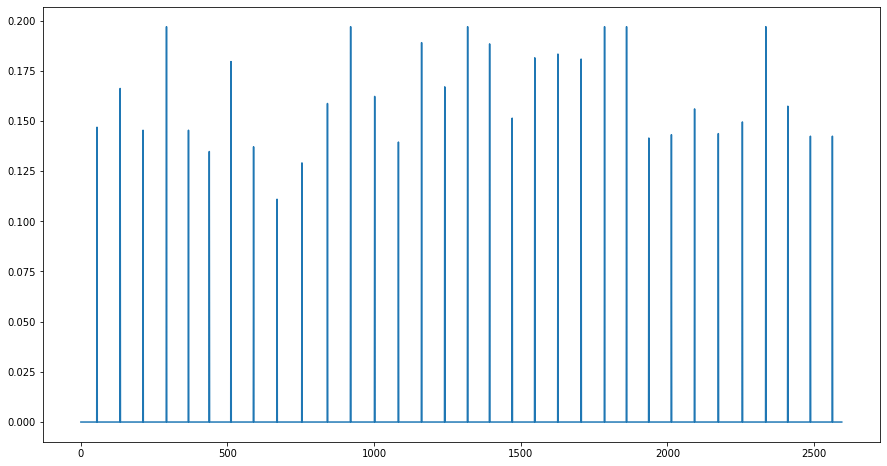

In [30]:
ecg_max_amplitude = np.max(ecg_signal)
peak_threshold = 0.4 * ecg_max_amplitude

## cut off at threshold
peak_signal = np.vectorize(lambda x: (x if x > peak_threshold else 0.0))(squared_ecg_signal)
peaks = [i for i in range(len(peak_signal)) if peak_signal[i] > peak_threshold]

## moving window sweep (width: 30) to eliminate neighbors with high values
for i in peaks:
    start = max(0, i - 15)
    end = min(len(peak_signal) - 1, i + 15)
    
    peak_location = np.argmax(peak_signal[start:end])
    for i in range(30):
        if i != peak_location:
            peak_signal[i + start] = 0.0
    
    

## all "fake" peaks have been eliminated, recalculate peaks
peaks = [i for i in range(len(peak_signal)) if peak_signal[i] > peak_threshold]

plt.plot(peak_signal)
peaks

## rMSSD
root mean square of successive differences (in R-R intervals)

Sampling freq: 100.04239084357779 Hz
HRV - rMSSD: 29.5 ms


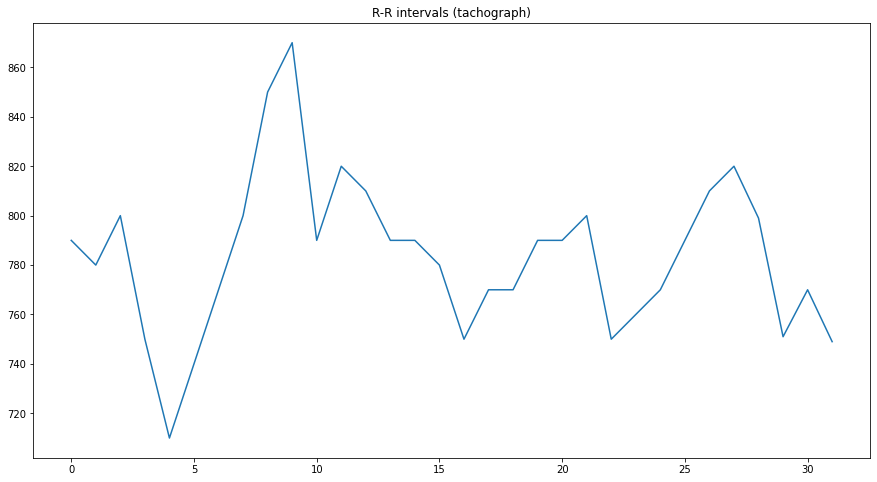

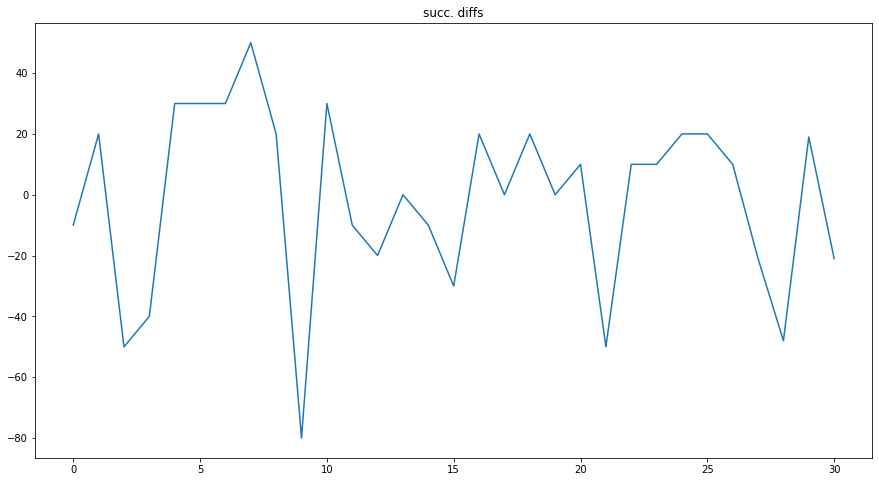

In [31]:
#sampling_freq = 50
sampling_freq = 1000.0 / ((ecg_recording[len(ecg_recording)-1]["clientTimestamp"] - ecg_recording[0]["clientTimestamp"]) / len(ecg_recording))
print(f"Sampling freq: {sampling_freq} Hz")

rr_intervals = [] # ms
for i in range(len(peaks) - 1):
    time_diff = ecg_recording[peaks[i+1]]["clientTimestamp"] - ecg_recording[peaks[i]]["clientTimestamp"]
    rr_intervals.append(time_diff)
rr_intervals = np.array(rr_intervals)

plt.title("R-R intervals (tachograph)")
plot(rr_intervals)

successive_differences = []
for i in range(len(rr_intervals)-1):
    diff = rr_intervals[i+1] - rr_intervals[i]
    successive_differences.append(diff)
successive_differences = np.array(successive_differences)

fig = plt.figure()
plt.title("succ. diffs")
plot(successive_differences)

rMSSD = np.sqrt(np.mean(successive_differences ** 2))

print(f"HRV - rMSSD: {round(rMSSD * 10.0) / 10.0} ms")

## Poincare plot

In [27]:
xData = []
yData = []

for i in range(len(successive_differences)-1):
    xData.append(successive_differences[i])
    yData.append(successive_differences[i+1])

fig = plt.figure()
plt.title("Poincare plot")
plt.xlabel("RR_n (ms)")
plt.ylabel("RR_n+1 (ms)")
plt.scatter(xData, yData)

NameError: name 'successive_differences' is not defined